# Multi-Armed Bandit with Gymnasium Environment Registration and Observation Wrapper Example

In [1]:
# Importing necessary libraries
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium import ObservationWrapper
import matplotlib.pyplot as plt

## Creating the Multi-Armed Bandit Environment

In [2]:
class MultiArmedBanditEnv(gym.Env):
    """ Bandit that allways provides a payout upon taking an action.

    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    
    def __init__(self, num_arms=5):
        super(MultiArmedBanditEnv, self).__init__()
        self.action_space = spaces.Discrete(num_arms)
        self.observation_space = spaces.Discrete(1)

        # define Bandit payouts/rewards
        self.prob_dist = np.full(num_arms, 1)
        self.reward_dist_mu = np.random.normal(1, 1, (num_arms,))  # q*(a)
        self.reward_dist_sigma = np.repeat(1, num_arms)
        self.cap_reward()

        # special case for bandit
        self.state = 0
        
    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"
        
        reward = np.random.normal(self.reward_dist_mu[action], self.reward_dist_sigma[action])
        done = True  # Each step is terminal in a multi-armed bandit
        truncated = False
        info = {}

        return self.state, reward, done, truncated, info
    
    def reset(self, seed=None, options=None):
        # Seed the RNG if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        self.state = 0
        return self.state, {}
    
    def render(self, mode="human"):
        pass

    def cap_reward(self, min_max=2):
        self.reward_dist_mu = np.clip(self.reward_dist_mu, -min_max, min_max)

    @property
    def optimal_arm(self):
        return np.argmax(env.unwrapped.action_values)
    
    @property
    def action_values(self):
        return self.reward_dist_mu

## Register the environment with gymnasium

In [3]:
register(
    id='MultiArmedBandit-v0',
    entry_point=MultiArmedBanditEnv,
    max_episode_steps=1,
)

## Simulating the Bandit Problem

In [4]:
def simulate(env, num_pulls, strategy='random'):
    env.reset()
    num_actions = env.action_space.n
    
    rewards = np.zeros(num_pulls)     # Rewards at each step (for plotting)
    counts = np.zeros([num_actions])  # Count of pulls per action
    q_values = np.zeros([num_actions])  # Estimated Q-values (cumulative rewards per action)
    q_values_history = np.zeros([num_pulls, num_actions])  # To track Q-values at each step
    
    # Start simulation loop
    for i in range(num_pulls):
        
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            if i > 0:
                # Exploit: choose the action with the highest estimated Q-value
                q_estimates = q_values / np.maximum(1, counts)  # Avoid division by zero
                action = np.argmax(q_estimates)
            else:
                # Random initial pull
                action = env.action_space.sample()
        
        _, reward, _, _, _ = env.step(action)
        
        # Update counts and Q-values for the selected action
        counts[action] += 1
        q_values[action] += reward  # Update cumulative reward for this action
        rewards[i] = reward  # Log reward for this step
        
        # Track Q-values at each step (for plotting later)
        q_values_history[i] = q_values / np.maximum(1, counts)  # Average Q-values
    
    return rewards, q_values_history  # Return both rewards and Q-values history

In [5]:
# Check optimal arm probabilities
env = gym.make('MultiArmedBandit-v0', num_arms=5)
print(f"Optimal arm: {env.unwrapped.optimal_arm} with probabilities {env.unwrapped.action_values}")

# Simulate
num_pulls = 4_000
rewards_random, q_values_random = simulate(env, num_pulls, strategy='random')
rewards_greedy, q_values_greedy = simulate(env, num_pulls, strategy='greedy')  

Optimal arm: 0 with probabilities [ 2.          1.31002503  2.         -0.43688196  0.29968931]


## Visualization

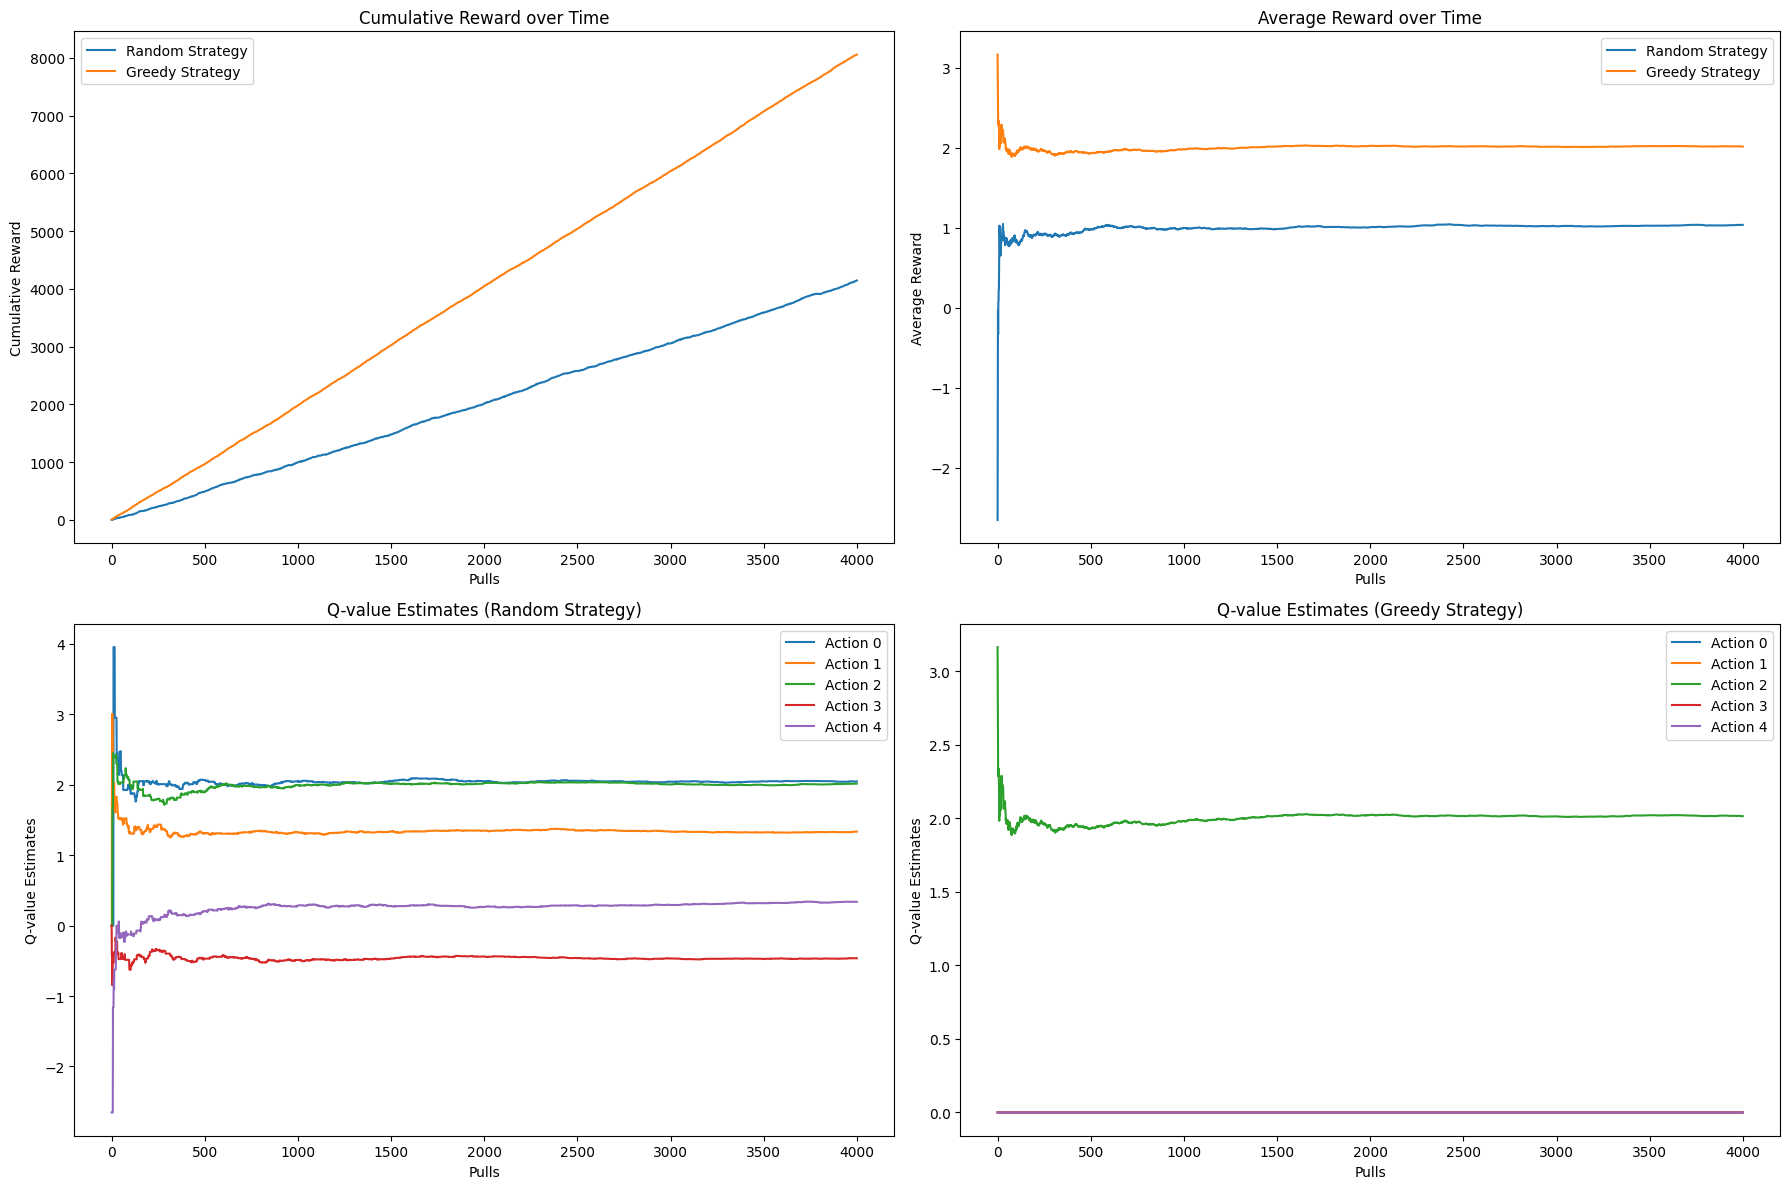

In [6]:
plt.figure(figsize=(18, 12))

# Plot cumulative rewards
plt.subplot(2, 2, 1)
plt.plot(np.cumsum(rewards_random), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()

# Plot average reward
plt.subplot(2, 2, 2)
plt.plot(np.cumsum(rewards_random) / np.arange(1, num_pulls + 1), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy) / np.arange(1, num_pulls + 1), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()

# Plot Q-values (Random Strategy)
plt.subplot(2, 2, 3)
for action in range(env.action_space.n):
    plt.plot(q_values_random[:, action], label=f'Action {action}')
plt.xlabel('Pulls')
plt.ylabel('Q-value Estimates')
plt.title('Q-value Estimates (Random Strategy)')
plt.legend()

# Plot Q-values (Greedy Strategy)
plt.subplot(2, 2, 4)
for action in range(env.action_space.n):
    plt.plot(q_values_greedy[:, action], label=f'Action {action}')
plt.xlabel('Pulls')
plt.ylabel('Q-value Estimates')
plt.title('Q-value Estimates (Greedy Strategy)')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Uncertainty-Estimating Wrapper

Problem: Bandit problems often involve balancing between exploring unknown arms and exploiting known good arms. Providing an explicit uncertainty measure can improve exploration strategies.

Solution: A wrapper could keep track of the variance or other measures of uncertainty associated with each action’s reward and return this information to the agent. This can be useful in algorithms like Upper Confidence Bound (UCB) or Thompson Sampling.

In [7]:
class UncertaintyWrapper(gym.Wrapper):
    def __init__(self, env):
        super(UncertaintyWrapper, self).__init__(env)
        self.action_counts = np.zeros(env.action_space.n)  # Count of times each action has been taken
        self.action_rewards = np.zeros(env.action_space.n)  # Sum of rewards for each action
        self.action_rewards_squared = np.zeros(env.action_space.n)  # Sum of squared rewards for variance calculation

    def step(self, action):
        # perform step with 
        obs, reward, done, truncated, info = self.env.step(action)
        
        # Update reward statistics
        self.action_counts[action] += 1
        self.action_rewards[action] += reward
        self.action_rewards_squared[action] += reward ** 2
        
        # Calculate the mean and variance of the reward for the action
        mean_reward = self.action_rewards[action] / self.action_counts[action]
        variance_reward = (self.action_rewards_squared[action] / self.action_counts[action]) - mean_reward ** 2

        # Add the mean and variance to the info dictionary for access
        info['mean_reward'] = mean_reward
        info['reward_variance'] = variance_reward
        
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        
        base_env_reset = self.env.reset(**kwargs)
        
        # Reset statistics of wrapper
        self.action_counts = np.zeros(self.env.action_space.n)
        self.action_rewards = np.zeros(self.env.action_space.n)
        self.action_rewards_squared = np.zeros(self.env.action_space.n)
        
        return base_env_reset

In [8]:
def simulate_with_uncertainty(env, num_pulls, strategy='random'):
    rewards = np.zeros(num_pulls)  # Track rewards at each step
    action_counts = np.zeros(env.action_space.n)  # Count how many times each action is selected

    for i in range(num_pulls):
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            # Exploit: choose action with the highest estimated mean reward
            action = np.argmax(env.action_rewards / np.maximum(1, action_counts))
        else:
            action = env.action_space.sample()  # Fallback to random

        # Step in the environment and retrieve the augmented observation and reward
        obs, reward, done, truncated, info = env.step(action)
        rewards[i] = reward
        action_counts[action] += 1
        
        # Display mean and variance of the selected action
        print(f"Step {i + 1} - Action {action}:    Reward {reward:.2f},     Mean Reward {info['mean_reward']:.2f},    Variance {info['reward_variance']:.2f}")

    return rewards

# Wrap the environment with the uncertainty wrapper
env = MultiArmedBanditEnv(num_arms=5)
wrapped_env = UncertaintyWrapper(env)

# Run the simulation
num_pulls = 10
rewards = simulate_with_uncertainty(wrapped_env, num_pulls, strategy='random')

Step 1 - Action 4:    Reward 0.79,     Mean Reward 0.79,    Variance 0.00
Step 2 - Action 4:    Reward 0.29,     Mean Reward 0.54,    Variance 0.06
Step 3 - Action 0:    Reward 2.83,     Mean Reward 2.83,    Variance 0.00
Step 4 - Action 4:    Reward -0.34,     Mean Reward 0.25,    Variance 0.21
Step 5 - Action 0:    Reward 0.43,     Mean Reward 1.63,    Variance 1.44
Step 6 - Action 2:    Reward 0.53,     Mean Reward 0.53,    Variance 0.00
Step 7 - Action 1:    Reward 0.10,     Mean Reward 0.10,    Variance 0.00
Step 8 - Action 0:    Reward 2.87,     Mean Reward 2.05,    Variance 1.30
Step 9 - Action 4:    Reward 1.05,     Mean Reward 0.45,    Variance 0.28
Step 10 - Action 3:    Reward 3.03,     Mean Reward 3.03,    Variance 0.00


# Exercise

## Task 1: Implementing the UCB Algorithm
- adjust simulation Method
- run simulations with different values of the confidence parameter (c)

## Task 2: Creating a Wrapper for Dynamic Environments
- Design a Wrapper to Add Noise: add Gaussian noise to the rewards at each step
- Compare performane (avg. reward) of static and non-static environment

# Solution for Task 1

In [9]:
def simulate_with_ucb_algorithm(env, num_pulls, c=1):
    num_actions = env.action_space.n
    rewards = np.zeros(num_pulls)
    action_counts = np.zeros(num_actions)
    q_values = np.zeros(num_actions)
    chosen_arms = np.zeros(num_pulls, dtype=int)
    optimal_arms = np.zeros(num_pulls, dtype=int)
    
    env.reset()
    for i in range(num_pulls):
        if i < num_actions:
            action = i  # ensure each action is selected at least once at first
        else:
            ucb_values = q_values + c * np.sqrt(np.log(i) / action_counts)
            action = np.argmax(ucb_values)

        _, reward, _, _, _ = env.step(action)
        rewards[i] = reward

        # Update counts and Q-values (iterative update formula)
        action_counts[action] += 1
        q_values[action] = q_values[action] + (1/action_counts[action]) * (reward - q_values[action])

        # logging
        chosen_arms[i] = action
        optimal_arms[i] = env.unwrapped.optimal_arm
    
    return rewards, chosen_arms, optimal_arms

env = gym.make('MultiArmedBandit-v0', num_arms=5)
num_pulls = 10000
rewards_ucb_static, chosen_arms_ucb_static, optimal_arms_ucb_static = simulate_with_ucb_algorithm(env, num_pulls)

# Solution for Task 2

In [19]:
import random

class DynamicWrapper(gym.Wrapper):
    """
    Adjusts every 'change_interval' the reward distributions mean.
    """
    
    def __init__(self, env, adjust_std=2, change_interval=50):
        super(DynamicWrapper, self).__init__(env)
        self.adjust_std = adjust_std
        self.change_interval = change_interval
        self.steps = 0

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.steps += 1

        # Periodically change the action values
        if self.steps % self.change_interval == 0:
            self.modify_action_values()
            self.unwrapped.cap_reward()
        
        return obs, reward, done, truncated, info

    def modify_action_values(self):
        num_arms = self.env.action_space.n
        self.env.unwrapped.reward_dist_mu += np.random.normal(0, self.adjust_std, self.env.unwrapped.reward_dist_mu.shape)

    def reset(self, **kwargs):
        self.steps = 0
        return self.env.reset(**kwargs)

# Wrap the existing environment
dynamic_env = DynamicWrapper(env)

# Test the UCB algorithm with the dynamic environment
rewards_ucb_dynamic, chosen_arms_ucb_dynamic, optimal_arms_ucb_dynamic = simulate_with_ucb_algorithm(dynamic_env, num_pulls)

# Plot results

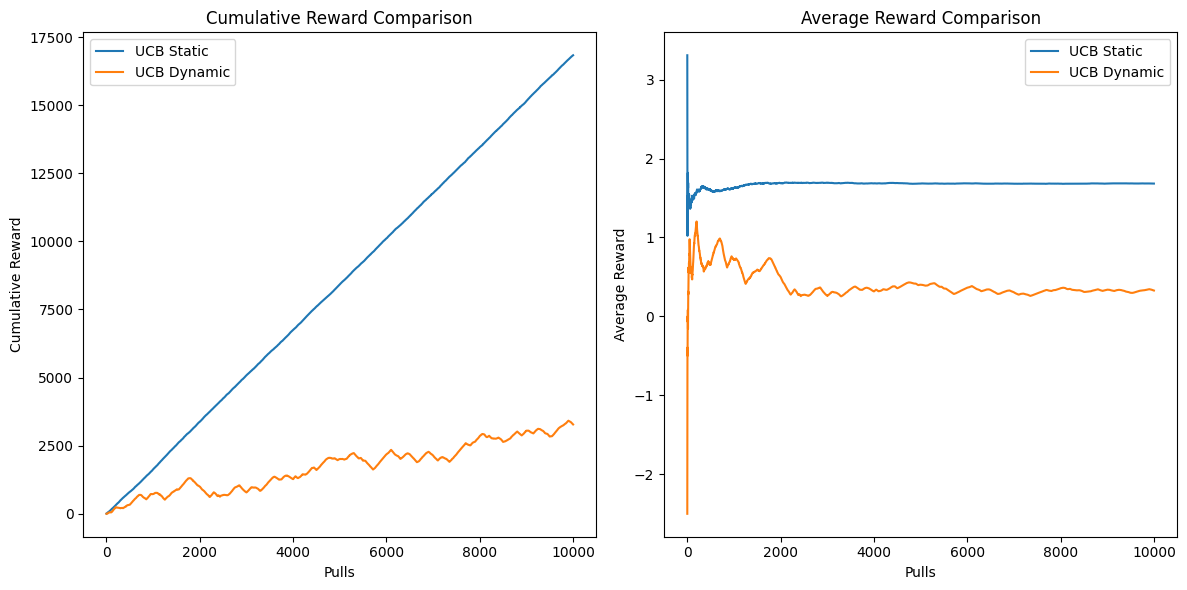

In [20]:
plt.figure(figsize=(12, 6))

# Plot cumulative rewards comparison
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(rewards_ucb_static), label='UCB Static')
plt.plot(np.cumsum(rewards_ucb_dynamic), label='UCB Dynamic')
plt.xlabel('Pulls')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()

# Plot average reward comparison
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(rewards_ucb_static) / np.arange(1, num_pulls + 1), label='UCB Static')
plt.plot(np.cumsum(rewards_ucb_dynamic) / np.arange(1, num_pulls + 1), label='UCB Dynamic')
plt.xlabel('Pulls')
plt.ylabel('Average Reward')
plt.title('Average Reward Comparison')
plt.legend()

plt.tight_layout()
plt.show()

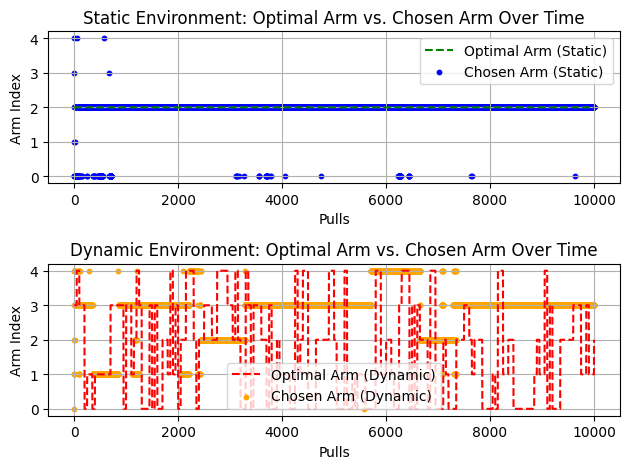

In [21]:
pulls = np.arange(1, num_pulls + 1)

# Plot for static environment
plt.subplot(2, 1, 1)
plt.plot(pulls, optimal_arms_ucb_static, label='Optimal Arm (Static)', linestyle='--', color='green')
plt.scatter(pulls, chosen_arms_ucb_static, label='Chosen Arm (Static)', color='blue', s=10)
plt.xlabel('Pulls')
plt.ylabel('Arm Index')
plt.title('Static Environment: Optimal Arm vs. Chosen Arm Over Time')
plt.legend()
plt.grid(True)

# Plot for dynamic environment
plt.subplot(2, 1, 2)
plt.plot(pulls, optimal_arms_ucb_dynamic, label='Optimal Arm (Dynamic)', linestyle='--', color='red')
plt.scatter(pulls, chosen_arms_ucb_dynamic, label='Chosen Arm (Dynamic)', color='orange', s=10)
plt.xlabel('Pulls')
plt.ylabel('Arm Index')
plt.title('Dynamic Environment: Optimal Arm vs. Chosen Arm Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Take Home Message - Limitations of UCB in Dynamic Environments

1. Static UCB Assumption: The classic Upper Confidence Bound (UCB) algorithm assumes stationary distributions; it balances exploration and exploitation based on historical data but does not inherently adapt to changes in the reward distributions over time. This can lead to suboptimal performance when the reward distributions are dynamic.

2. Late Exploration: As the number of pulls increases, UCB's confidence intervals narrow, focusing more on exploitation. This makes the UCB algorithm less responsive to changes in the environment, as it relies heavily on initial estimations and the 'confidence bonus' reduces over time.

The notebook's implementation of a dynamic environment tests UCB's adaptability. When run in this setup, UCB might fail to quickly adapt to changing reward distributions, illustrating its limitations in dynamic settings.


## Addressing Non-Stationarity
While the notebook highlights these challenges via simulation, it doesn't provide a solution within the implemented tasks. However, several approaches can help UCB handle non-stationary environments:

1. Sliding Window UCB: By keeping a sliding window of recent observations, the algorithm can remain sensitive to recent changes rather than relying on the entire history.

2. Discounted UCB: Applying a discount factor to older rewards can prioritize recent observations, allowing the algorithm to react more fluidly to shifts in reward distributions.